In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.metrics import accuracy_score,f1_score,mean_squared_log_error, SCORERS
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.svm import SVC,SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Lasso, Ridge

# Train

In [3]:
def concat(train_data, test_data):
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

def drop_sur(all_data):
    return all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)

In [5]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_all = concat(df_train, df_test)
dfs = [df_train, df_test]

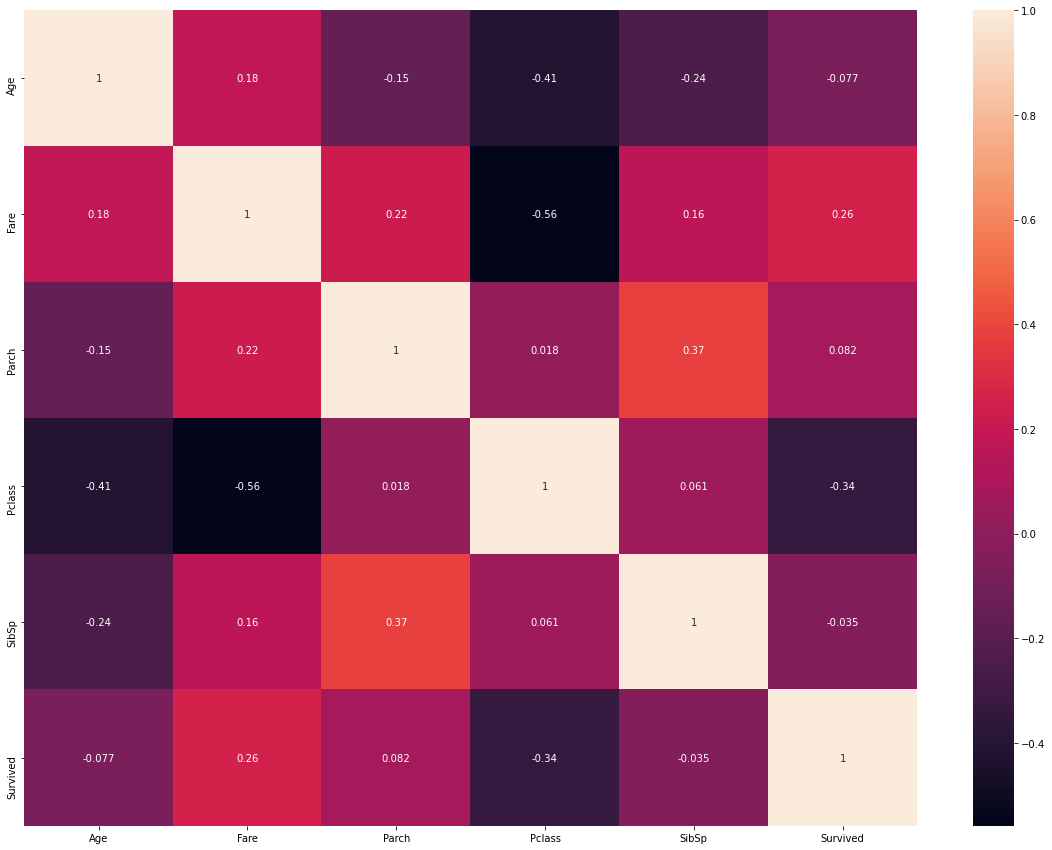

In [6]:
plt.figure(figsize=(20, 15))
sns.heatmap(df_all.drop(columns=['PassengerId']).corr(), annot=True);

In [7]:
df_all['Sex_binary'] = df_all['Sex'].map({'female': 0, 'male': 1}).astype(int)

In [8]:
df_all_corr = df_all.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_all_corr.rename(columns={'level_0': 'Feature', 'level_1': 'All Features', 0: 'Correlation Coefficient'}, inplace=True)
df_all_corr[df_all_corr['Feature'] == 'Age']

,Feature,All Features,Correlation Coefficient
0,Age,Age,1.000000
12,Age,Pclass,0.408106
21,Age,SibSp,0.243699
28,Age,Fare,0.178740
33,Age,Parch,0.150917
40,Age,Survived,0.077221
43,Age,Sex_binary,0.063645
54,Age,PassengerId,0.028814


In [9]:
age_class = df_all.groupby(['Sex', 'Pclass']).median()['Age']
for cl in range(1, 4):
    for sex in ['female', 'male']:
        print(' Pclass {} {}s: {}'.format(cl, sex, age_class[sex][cl]))
print('Средний возраст : {}'.format(df_all['Age'].median()))

 Pclass 1 females: 36.0
 Pclass 1 males: 42.0
 Pclass 2 females: 28.0
 Pclass 2 males: 29.5
 Pclass 3 females: 22.0
 Pclass 3 males: 25.0
Средний возраст : 28.0


In [10]:
df_all['Age'] = df_all.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

In [11]:
df_all['Embarked'] = df_all['Embarked'].fillna('S')

In [12]:
m_f = df_all.groupby(['Pclass', 'Parch', 'SibSp', 'Sex_binary']).Fare.median()[3][0][0][1]

In [13]:
df_all['Fare'] = df_all['Fare'].fillna(m_f)

In [14]:
df_all['Deck'] = df_all['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')

In [15]:
df_all['Dsurv'] = df_all['Deck']
df_all['Dsurv'] = df_all['Dsurv'].replace(['B', 'D', 'E'], 'BDE')
df_all['Dsurv'] = df_all['Dsurv'].replace(['C', 'F'], 'CF')
df_all['Dsurv'] = df_all['Dsurv'].replace(['A', 'G'], 'AG')

df_all['Dsurv'].value_counts()

M      1014
BDE     152
CF      115
AG       27
T         1
Name: Dsurv, dtype: int64

In [16]:
df_all['FamilySize'] = df_all['SibSp'] + df_all['Parch'] + 1
df_all['IsAlone'] = 0
df_all.loc[df_all['FamilySize'] == 1, 'IsAlone'] = 1

In [17]:
family_map = {1: 0, 
              2: 1, 
              3: 1, 
              4: 2, 
              5: 2, 
              6: 3, 
              7: 3, 
              8: 3, 
              11: 3}
df_all['Family_size'] = df_all['FamilySize'].map(family_map)

In [18]:
df_all['Family_size']

0       1
1       1
2       0
3       1
4       0
       ..
1304    0
1305    0
1306    0
1307    0
1308    1
Name: Family_size, Length: 1309, dtype: int64

In [19]:
df_all = pd.concat([df_all, pd.get_dummies(df_all['Family_size'], prefix='Fs')], axis=1)

In [20]:
df_all.drop('Family_size', axis=1, inplace=True)

In [21]:
df_all['Deck'] = df_all['Deck'].replace(['A', 'B', 'C'], 'ABC') # 1 класс
df_all['Deck'] = df_all['Deck'].replace(['D', 'E'], 'DE') # Все классы 
df_all['Deck'] = df_all['Deck'].replace(['F', 'G'], 'FG') # 2 и 3 класс
df_all['Deck'].value_counts()

M      1014
ABC     181
DE       87
FG       26
T         1
Name: Deck, dtype: int64

In [22]:
df_all.drop(['Cabin'], inplace=True, axis=1)
df_all.drop(['Sex'], inplace=True, axis=1)


In [23]:
#df_train, df_test = drop_sur(df_all)
#df_train, df_test = floordiv(df_all)

In [24]:
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [25]:
df_all = pd.concat([df_all, pd.get_dummies(df_all['Embarked'], prefix='Embarked')], axis=1)
df_all.drop('Embarked', axis=1, inplace=True)

In [26]:
def title(name):
    '''Находим точку в колонке имени, т.е. находим обращение по титулу 
    или к замужней или незамужней'''
    if '.' in name:
        return name.split(',')[1].split('.')[0].strip()
    else:
        return 'Unknown'
df_all['Title'] = df_all['Name'].map(lambda name: title(name))

In [27]:
df_all['Title'] = df_all['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme','the Countess', 'Dona'], 'Miss/Mrs/Ms')
df_all['Title'] = df_all['Title'].replace(['Dr', 'Col', 'Major','Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')

In [28]:
df_train, df_test = drop_sur(df_all)

In [29]:
dfs = [df_train, df_test]

In [30]:
df_train.columns

Index(['Age', 'Fare', 'Name', 'Parch', 'PassengerId', 'Pclass', 'SibSp',
       'Survived', 'Ticket', 'Sex_binary', 'Deck', 'Dsurv', 'FamilySize',
       'IsAlone', 'Fs_0', 'Fs_1', 'Fs_2', 'Fs_3', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'Title'],
      dtype='object')

In [31]:
mean_survival = np.mean(df_train['Survived'])
mean_survival

0.3838383838383838

In [32]:
nnfeatures = ['Deck', 'Dsurv', 'Title']
for df in dfs:
    for feature in nnfeatures:        
        df.loc[:,feature] = LabelEncoder().fit_transform(df.loc[:,feature])

C:\Users\ryzhk\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [33]:
features = ['Pclass', 'Sex_binary', 'Dsurv', 'Deck', 'Title']
encoded_features = []
for df in dfs:
    for feature in features:
        encoded_feat = OneHotEncoder().fit_transform(df[feature].values.reshape(-1, 1)).toarray()
        n = df[feature].nunique()
        cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
        encoded_df = pd.DataFrame(encoded_feat, columns=cols)
        encoded_df.index = df.index
        encoded_features.append(encoded_df)
df_train = pd.concat([df_train, *encoded_features[:len(features)]], axis=1)
df_test = pd.concat([df_test, *encoded_features[len(features):]], axis=1)

In [34]:
a = list(set(df_train.columns.to_list())-set(df_test.columns.to_list()))
a

['Dsurv_5', 'Survived', 'Deck_5']

In [35]:
#df_train.drop(a, axis=1, inplace=True)

In [36]:
df_train['AGE'] = df_train['Age'].apply(lambda x: 0 if x < 17 else 2 if x > 50 else 1)

In [37]:
df_train = pd.concat([df_train, pd.get_dummies(df_train['AGE'], prefix='A')], axis=1)

In [38]:
df_train.drop('AGE', axis=1, inplace=True)

In [39]:
df_test['AGE'] = df_test['Age'].apply(lambda x: 0 if x < 17 else 2 if x > 50 else 1)

In [40]:
df_test = pd.concat([df_test, pd.get_dummies(df_test['AGE'], prefix='A')], axis=1)

In [41]:
df_test.drop('AGE', axis=1, inplace=True)

In [42]:
df_train.columns.to_list()

['Age',
 'Fare',
 'Name',
 'Parch',
 'PassengerId',
 'Pclass',
 'SibSp',
 'Survived',
 'Ticket',
 'Sex_binary',
 'Deck',
 'Dsurv',
 'FamilySize',
 'IsAlone',
 'Fs_0',
 'Fs_1',
 'Fs_2',
 'Fs_3',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S',
 'Title',
 'Pclass_1',
 'Pclass_2',
 'Pclass_3',
 'Sex_binary_1',
 'Sex_binary_2',
 'Dsurv_1',
 'Dsurv_2',
 'Dsurv_3',
 'Dsurv_4',
 'Dsurv_5',
 'Deck_1',
 'Deck_2',
 'Deck_3',
 'Deck_4',
 'Deck_5',
 'Title_1',
 'Title_2',
 'Title_3',
 'Title_4',
 'A_0',
 'A_1',
 'A_2']

In [43]:
features = ['Age','Fare','Name','Parch','PassengerId','Pclass','SibSp','Survived','Ticket','Sex_binary','Deck','Dsurv','Fs_0','Fs_1','Fs_2','Fs_3',
 'Embarked_C','Embarked_Q','Embarked_S','Title','Pclass_1','Pclass_2',
 'Pclass_3','Sex_binary_1','Sex_binary_2','Dsurv_1','Dsurv_2','Dsurv_3','Dsurv_4','Dsurv_5','Deck_1','Deck_2','Deck_3',
 'Deck_4','Deck_5','Title_1','Title_2','Title_3','Title_4','A_0','A_1','A_2']
target = ['Survived']
len(features)

42

In [44]:
corr_data = pd.DataFrame(df_train.drop('Survived', axis=1) .corrwith(df_train['Survived'], axis=0, drop=False), 
             index=(df_train[features].columns), 
             columns=['Corr']).sort_values('Corr')
corr_data[corr_data['Corr'] > .2].sort_values('Corr', ascending=False)

,Corr
Sex_binary_1,0.543351
Title_3,0.540769
Pclass_1,0.285904
Dsurv_2,0.285490
Fare,0.257307
Fs_1,0.238059
Deck_2,0.213430
Deck_1,0.205840


In [45]:
corr_data[corr_data['Corr'] < -.2].sort_values('Corr')

,Corr
Title_4,-0.549199
Sex_binary_2,-0.543351
Sex_binary,-0.543351
Title,-0.402510
Pclass,-0.338481
Pclass_3,-0.322308
Deck_4,-0.316912
Dsurv_4,-0.316912
Deck,-0.301594
Dsurv,-0.301418


In [46]:
new_features = corr_data[corr_data['Corr'] > .2].sort_values('Corr', ascending=False).index.to_list() + corr_data[corr_data['Corr'] < -.2].sort_values('Corr').index.to_list()

In [47]:
df_train_X = df_train[new_features]

In [48]:
df_train_Y = df_train[target].astype(int)

In [49]:
x_tr, y_tr = df_train_X.to_numpy(), df_train_Y.to_numpy()
scaler = StandardScaler()
X = scaler.fit_transform(x_tr)

In [50]:
x_test = df_test[new_features].to_numpy()
X_test= scaler.transform(x_test)

In [51]:
 y_tr = np.array(y_tr).ravel()

# Test

In [52]:
def function (x_train,y_train, x_test, model, params, n, target, features):
    best_models = []
    datafr = pd.concat([pd.Series(y_train, name=target), pd.DataFrame(x_train, columns=features)], axis=1)
    for i in range(1, n+1):
        func = datafr.sample(len(x_train), replace = True)
        x_train, y_train = func[features].to_numpy(), func[target].astype(int).to_numpy()
        clf = model(**params)
        clf.fit(x_train,y_train)
        result = clf.predict(x_test)
        best_models.append(result)
    b = np.asarray(best_models).sum(axis=0)
    fin_res = []
    for j in b:
        if j/n >= 0.5:
            fin_res.append(1)
        else:
            fin_res.append(0)
    return fin_res       

In [53]:
outcome = function(X, y_tr, X_test , DecisionTreeClassifier, {'max_depth':8, 'min_samples_split':3}, 1000, 'Survived', new_features)

In [54]:
df_test['Survived'] = outcome

In [ ]:
df_test[['PassengerId', 'Survived']].to_csv('titanic_sub8.csv', index=False)

In [ ]:
df_test[['PassengerId','Survived']]

In [387]:
x_train, x_test, y_train, y_test = train_test_split(X, df_train_Y.to_numpy())

In [388]:
from sklearn.ensemble import RandomForestClassifier
clf_1 = RandomForestClassifier()
params = {'n_estimators':[100,200,300],
              'max_depth':[3,5,8,11],
              'min_samples_split':[2,3,4]}
cv_1 = GridSearchCV(clf_1,
                       param_grid=params,
                       scoring='accuracy', 
                       cv=5, # делим на 5 частей
                       refit=True, # Выберет самую хорошую модель и применит на тестовуб
                       n_jobs=4,# сколько потоков считать
                       verbose=5)
print(cv_1.fit(X, y_tr).score(x_test, y_test))
cv_1.best_params_, cv_1.best_score_

Fitting 5 folds for each of 36 candidates, totalling 180 fits
0.7892376681614349


({'max_depth': 11, 'min_samples_split': 2, 'n_estimators': 100},
 0.786793045006591)

In [391]:
clf_22 = DecisionTreeClassifier()
params22 = {'max_depth':np.arange(1,20,15),
          'min_samples_split':np.arange(1,10,1)}
cv_22 = GridSearchCV(clf_22,
                    param_grid=params22,
                    scoring='accuracy', 
                    cv=5, # делим на 5 частей
                    refit=True, # Выберет самую хорошую модель и применит на тестовуб
                    n_jobs=4,# сколько потоков считать
                    verbose=5)
cv_22.fit(X, y_tr)
cv_22.best_params_, cv_22.best_score_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


C:\Users\ryzhk\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.77889649 0.77889649 0.77889649 0.77889649 0.77889649
 0.77889649 0.77889649 0.77889649        nan 0.77443977 0.77443977
 0.77331618 0.77331618 0.77443977 0.77443977 0.77443977 0.77443977]
  warnings.warn(


({'max_depth': 1, 'min_samples_split': 2}, 0.7788964911179461)

In [248]:
clf_3 = KNeighborsClassifier()
params = {'n_neighbors':[2,4,6,8],
          'weights':['uniform','distance'],
          'p':[2,3,4,5]}
cv_3 = GridSearchCV(clf_3,
                   param_grid=params,
                   scoring='accuracy', 
                       cv=5, # делим на 5 частей
                       refit=True, # Выберет самую хорошую модель и применит на тестовуб
                       n_jobs=4,# сколько потоков считать
                       verbose=5)
print(cv_3.fit(X, y_tr).score(x_test, y_test))
cv_3.best_params_, cv_3.best_score_

Fitting 5 folds for each of 32 candidates, totalling 160 fits
0.8071748878923767


({'n_neighbors': 8, 'p': 2, 'weights': 'distance'}, 0.7946582135459168)

In [249]:
from sklearn.ensemble import StackingClassifier
estimators = [('model_1', RandomForestClassifier(max_depth=5,min_samples_split=3, n_estimators=100)),
             ('model_2', KNeighborsClassifier(n_neighbors=8, p=4, weights='distance'))]
clf_2 = StackingClassifier(estimators=estimators, final_estimator=SVC())
print(clf_2.fit(X, y_tr).score(x_test, y_test))
clf_2.predict(x_test).astype(int)

0.8071748878923767


array([1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0])